## Code

### Mounting Drive to save the model:

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


### Getting Data from the user: 

Current Dataset: [Student_performance_parameters_final_without_result.xlsx](https://docs.google.com/spreadsheets/d/1Vl-VpRlwDlaAdgnK8f9dqXYAUGUE9jfz/edit?usp=sharing&ouid=108334363958270871098&rtpof=true&sd=true)

In [2]:
#@title Upload Historical Data:

#@markdown ---

from google.colab import files

uploaded = files.upload()

file_name = list(uploaded.keys())[0]

Saving Student_performance_parameters_final_without_rating.xlsx to Student_performance_parameters_final_without_rating.xlsx


In [3]:
#@title Select the Semester and Paper(s): { run: "auto" }

#@markdown ### Select Semester:

Semester = 'Sem_6' #@param ["Sem_1", "Sem_2", "Sem_3", "Sem_4", "Sem_5", "Sem_6", "Sem_7", "Sem_8"]


In [4]:
key = Semester

In [5]:
#@title Select Parameters to consider: { run: "auto" }

#@markdown ---

Subject_Content = True #@param {type:"boolean"}
Teacher_Rating = False #@param {type:"boolean"}
Subject_Interest = False #@param {type:"boolean"}
Practical_Knowledge = False #@param {type:"boolean"}
Likely_to_recommend = False #@param {type:"boolean"}

In [6]:
parameters = [] #matches headers
if Subject_Content:
  parameters.append("subject_content")

if Teacher_Rating:
  parameters.append("teacher_rating")

if Subject_Interest:
  parameters.append("subject_interest")

if Practical_Knowledge:
  parameters.append("practical_knowledge")

if Likely_to_recommend:
  parameters.append("likely_to_recommend")

In [7]:
# min rating 1/3 of max possible
min_rating = (len(parameters)*20)/3
min_rating

6.666666666666667

### Importing Libraries


In [8]:
import numpy as np
import pandas as pd

In [9]:
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [10]:
from keras import Sequential
from keras.layers import Embedding, Dropout, LSTM, Dense

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
import matplotlib.pyplot as plt

### Preparing the Data

In [13]:
### Input and get the semester:
df = pd.read_excel(file_name, sheet_name='Sheet1')

df_dict_sem = {}
for name in df['Semster_Name'].unique():
    df_dict_sem[name] = df[df['Semster_Name'] == name].reset_index(drop=True)

df_sem = df_dict_sem[key]

In [14]:
#Computing Rating for all
df_sem["Rating"] = 0
for parameter in parameters:
  df_sem["Rating"] += df_sem[parameter] 

In [15]:
#Applying Rating Threshold
df_sem_min_rating = df_sem[df_sem['Rating'] > min_rating].reset_index(drop=True)
df_sem_min_rating.head()

,Unnamed: 0,Student_ID,Semster_Name,Paper_ID,Paper_Name,subject_content,teacher_rating,subject_interest,practical_knowledge,likely_to_recommend,Rating
0,34,SID20131143,Sem_6,SEMI0068923,Paper 1,19,20,19,19,16,19
1,35,SID20131143,Sem_6,SEMI0067259,Paper 2,13,15,19,18,19,13
2,36,SID20131143,Sem_6,SEMI0065623,Paper 3,10,9,8,11,8,10
3,37,SID20131143,Sem_6,SEMI0064181,Paper 4,16,15,17,13,15,16
4,38,SID20131143,Sem_6,SEMI0064427,Paper 5,13,8,12,6,15,13


In [16]:
df_sem_min_rating = df_sem_min_rating[['Student_ID', 'Paper_Name', 'Rating']]
df_sem_min_rating.head()

,Student_ID,Paper_Name,Rating
0,SID20131143,Paper 1,19
1,SID20131143,Paper 2,13
2,SID20131143,Paper 3,10
3,SID20131143,Paper 4,16
4,SID20131143,Paper 5,13


### Data Prepocessing

In [17]:
#Drop rows with missing values
data_raw = df_sem_min_rating.dropna()

In [18]:
#put names into numerical IDs
data_raw['student_cat_id'] = data_raw['Student_ID'].astype("category").cat.codes + 1 #0's used for padding later
data_raw['paper_cat_id'] = data_raw['Paper_Name'].astype("category").cat.codes + 1 #0's used for padding later
data_raw.head()

,Student_ID,Paper_Name,Rating,student_cat_id,paper_cat_id
0,SID20131143,Paper 1,19,1,1
1,SID20131143,Paper 2,13,1,2
2,SID20131143,Paper 3,10,1,3
3,SID20131143,Paper 4,16,1,4
4,SID20131143,Paper 5,13,1,5


In [19]:
#Lookup frame to get student id back in readable form later
student_lookup = data_raw[['student_cat_id', 'Student_ID']].drop_duplicates()
student_lookup['student_cat_id'] = student_lookup.student_cat_id.astype(str)
student_lookup.head()

,student_cat_id,Student_ID
0,1,SID20131143
7,2,SID20131151
14,3,SID20131171
20,4,SID20131176
27,5,SID20131177


In [20]:
#Lookup frame to get paper names back in readable form later
item_lookup = data_raw[['paper_cat_id', 'Paper_Name']].drop_duplicates()
item_lookup['paper_cat_id'] = item_lookup.paper_cat_id.astype(str)
item_lookup.head()

,paper_cat_id,Paper_Name
0,1,Paper 1
1,2,Paper 2
2,3,Paper 3
3,4,Paper 4
4,5,Paper 5


In [21]:
#Dropping Student_ID and Paper_Name 
data_raw = data_raw.drop(['Student_ID', 'Paper_Name'], axis=1)
data_raw.head()

,Rating,student_cat_id,paper_cat_id
0,19,1,1
1,13,1,2
2,10,1,3
3,16,1,4
4,13,1,5


Instead of Discarding Rating values all together, we use them to order the data, highest first

In [22]:
data =  data_raw.groupby(['student_cat_id']).apply(lambda x: x.sort_values(["Rating"], ascending = False)).reset_index(drop=True)
data.head()

,Rating,student_cat_id,paper_cat_id
0,19,1,1
1,16,1,4
2,13,1,2
3,13,1,5
4,10,1,3


In [23]:
data = data.drop(['Rating'], axis = 1 )
data.head()

,student_cat_id,paper_cat_id
0,1,1
1,1,4
2,1,2
3,1,5
4,1,3


In [24]:
data.dtypes

student_cat_id    int16
paper_cat_id       int8
dtype: object

In [25]:
data['paper_cat_id'] = data['paper_cat_id'].apply(lambda x: [x])
data.head()

,student_cat_id,paper_cat_id
0,1,[1]
1,1,[4]
2,1,[2]
3,1,[5]
4,1,[3]


In [26]:
data = data.groupby('student_cat_id').agg({'paper_cat_id': 'sum'})
data.head()

,paper_cat_id
student_cat_id,
1,"[1, 4, 2, 5, 3, 6, 7]"
2,"[1, 4, 6, 3, 2, 5, 7]"
3,"[5, 7, 6, 3, 1, 4]"
4,"[6, 7, 4, 1, 5, 3, 2]"
5,"[1, 7, 3, 6, 2, 4, 5]"


Here we can select how many are needed i.e recommendations (-1)

In [27]:
data['target_sequences'] = data['paper_cat_id'].apply(lambda x: x[-1])
data.head()

,paper_cat_id,target_sequences
student_cat_id,,
1,"[1, 4, 2, 5, 3, 6, 7]",7
2,"[1, 4, 6, 3, 2, 5, 7]",7
3,"[5, 7, 6, 3, 1, 4]",4
4,"[6, 7, 4, 1, 5, 3, 2]",2
5,"[1, 7, 3, 6, 2, 4, 5]",5


In [28]:
data['paper_cat_id'] = data['paper_cat_id'].apply(lambda x: x[:-1])
data.head()

,paper_cat_id,target_sequences
student_cat_id,,
1,"[1, 4, 2, 5, 3, 6]",7
2,"[1, 4, 6, 3, 2, 5]",7
3,"[5, 7, 6, 3, 1]",4
4,"[6, 7, 4, 1, 5, 3]",2
5,"[1, 7, 3, 6, 2, 4]",5


In [29]:
#Length of greatest sequence
max_seq_len = data.paper_cat_id.apply(len).max()
max_seq_len

6

In [30]:
data['padded_sequences'] = pad_sequences(data.paper_cat_id, maxlen=max_seq_len, padding='pre', value=0).tolist()
data.head()

,paper_cat_id,target_sequences,padded_sequences
student_cat_id,,,
1,"[1, 4, 2, 5, 3, 6]",7,"[1, 4, 2, 5, 3, 6]"
2,"[1, 4, 6, 3, 2, 5]",7,"[1, 4, 6, 3, 2, 5]"
3,"[5, 7, 6, 3, 1]",4,"[0, 5, 7, 6, 3, 1]"
4,"[6, 7, 4, 1, 5, 3]",2,"[6, 7, 4, 1, 5, 3]"
5,"[1, 7, 3, 6, 2, 4]",5,"[1, 7, 3, 6, 2, 4]"


### Extracting Data and Preparing for Model

In [31]:
X = np.array(data.padded_sequences.tolist())
y = np.array(data.target_sequences.tolist())

In [32]:
print(X)
print(y)

[[1 4 2 5 3 6]
 [1 4 6 3 2 5]
 [0 5 7 6 3 1]
 ...
 [3 6 2 4 5 7]
 [1 3 2 4 5 6]
 [0 7 5 6 1 4]]
[7 7 4 ... 1 7 2]


In [33]:
#Number of classes
num_classes = int(item_lookup.paper_cat_id.max())+1
num_classes

8

In [34]:
#One hot encoding for targets
y = to_categorical(y, num_classes = num_classes)
print(y)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]]


In [35]:
ip_sh = X.shape[1]
ip_sh

6

### Model using Validation Split Method:

#### Defining and Training a Model

In [36]:
model = Sequential()
model.add(Embedding(num_classes, 5, input_length=max_seq_len))
model.add(Dropout(0.4))
model.add(LSTM(128, return_sequences=False, input_shape=(ip_sh,1)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 6, 5)              40        
                                                                 
 dropout (Dropout)           (None, 6, 5)              0         
                                                                 
 lstm (LSTM)                 (None, 128)               68608     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

In [38]:
history = model.fit(X, y, validation_split=0.2, verbose=1, epochs=1000)

Epoch 1/1000
96/96 [==============================] - 4s 18ms/step - loss: 2.0360 - acc: 0.1496 - val_loss: 1.9655 - val_acc: 0.2120
Epoch 2/1000
96/96 [==============================] - 1s 10ms/step - loss: 1.9020 - acc: 0.2383 - val_loss: 1.7499 - val_acc: 0.3089
Epoch 3/1000
96/96 [==============================] - 1s 11ms/step - loss: 1.7841 - acc: 0.2802 - val_loss: 1.6117 - val_acc: 0.3063
Epoch 4/1000
96/96 [==============================] - 1s 10ms/step - loss: 1.7384 - acc: 0.3041 - val_loss: 1.5675 - val_acc: 0.3259
Epoch 5/1000
96/96 [==============================] - 1s 11ms/step - loss: 1.7014 - acc: 0.3237 - val_loss: 1.5205 - val_acc: 0.3743
Epoch 6/1000
96/96 [==============================] - 1s 10ms/step - loss: 1.6754 - acc: 0.3411 - val_loss: 1.5030 - val_acc: 0.3338
Epoch 7/1000
96/96 [==============================] - 1s 10ms/step - loss: 1.6663 - acc: 0.3496 - val_loss: 1.4692 - val_acc: 0.4188
Epoch 8/1000
96/96 [==============================] - 1s 10ms/step - 

#### Plotting the results:

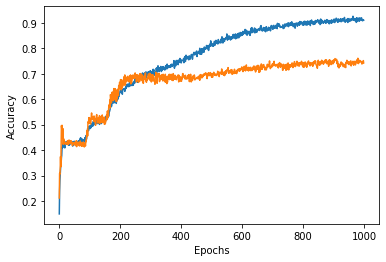

In [39]:
plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

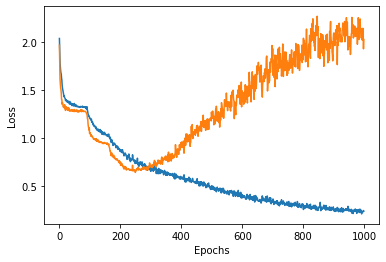

In [40]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Model using Train_test Split Method:

#### Defining and Training a Model

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [42]:
model = Sequential([
                    Embedding(num_classes, 5, input_length=max_seq_len),
                    Dropout(0.4),
                    LSTM(128, return_sequences=False, input_shape=(ip_sh,1)),
                    Dense(64, activation='relu'),
                    Dropout(0.4),
                    Dense(32, activation='relu'),
                    Dropout(0.4),
                    Dense(num_classes, activation='softmax'),
])

In [43]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 6, 5)              40        
                                                                 
 dropout_3 (Dropout)         (None, 6, 5)              0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               68608     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)               

In [44]:
#Training the Model
history = model.fit(X_train , y_train, epochs=1000, batch_size=128)

Epoch 1/1000
24/24 [==============================] - 3s 21ms/step - loss: 2.0580 - accuracy: 0.1538
Epoch 2/1000
24/24 [==============================] - 0s 20ms/step - loss: 2.0123 - accuracy: 0.1561
Epoch 3/1000
24/24 [==============================] - 0s 19ms/step - loss: 1.9923 - accuracy: 0.1656
Epoch 4/1000
24/24 [==============================] - 0s 20ms/step - loss: 1.9552 - accuracy: 0.1866
Epoch 5/1000
24/24 [==============================] - 0s 20ms/step - loss: 1.9018 - accuracy: 0.2187
Epoch 6/1000
24/24 [==============================] - 0s 21ms/step - loss: 1.8257 - accuracy: 0.2507
Epoch 7/1000
24/24 [==============================] - 0s 20ms/step - loss: 1.7661 - accuracy: 0.2789
Epoch 8/1000
24/24 [==============================] - 0s 20ms/step - loss: 1.7247 - accuracy: 0.3074
Epoch 9/1000
24/24 [==============================] - 0s 20ms/step - loss: 1.7372 - accuracy: 0.3002
Epoch 10/1000
24/24 [==============================] - 0s 20ms/step - loss: 1.7023 - accura

#### Plotting the results:

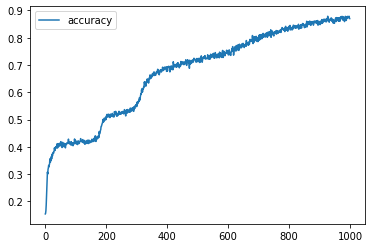

In [45]:
# plot the accuracy of the model as it trains
plt.plot(history.history['accuracy'])
plt.legend(['accuracy'])

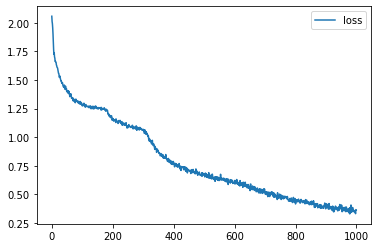

In [46]:
# plot the loss of the model as it trains
plt.plot(history.history['loss'])
plt.legend(['loss'])

In [47]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 1s 4ms/step - loss: 1.2764 - accuracy: 0.7251


[1.2763886451721191, 0.7251309156417847]

### Final Model Using All Available Data:

In [48]:
model = Sequential([
                    Embedding(num_classes, 5, input_length=max_seq_len),
                    Dropout(0.4),
                    LSTM(128, return_sequences=False, input_shape=(ip_sh,1)),
                    Dense(64, activation='relu'),
                    Dropout(0.4),
                    Dense(32, activation='relu'),
                    Dropout(0.4),
                    Dense(num_classes, activation='softmax'),
])

In [49]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 6, 5)              40        
                                                                 
 dropout_6 (Dropout)         (None, 6, 5)              0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               68608     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)               

In [50]:
#Training the Final Model
history = model.fit(X , y, epochs=1000, batch_size=128)

Epoch 1/1000
30/30 [==============================] - 3s 21ms/step - loss: 2.0459 - accuracy: 0.1605
Epoch 2/1000
30/30 [==============================] - 1s 20ms/step - loss: 2.0003 - accuracy: 0.1548
Epoch 3/1000
30/30 [==============================] - 1s 20ms/step - loss: 1.9617 - accuracy: 0.1859
Epoch 4/1000
30/30 [==============================] - 1s 19ms/step - loss: 1.8929 - accuracy: 0.2239
Epoch 5/1000
30/30 [==============================] - 1s 20ms/step - loss: 1.8366 - accuracy: 0.2535
Epoch 6/1000
30/30 [==============================] - 1s 19ms/step - loss: 1.7775 - accuracy: 0.2912
Epoch 7/1000
30/30 [==============================] - 1s 20ms/step - loss: 1.7599 - accuracy: 0.3019
Epoch 8/1000
30/30 [==============================] - 1s 20ms/step - loss: 1.7208 - accuracy: 0.3192
Epoch 9/1000
30/30 [==============================] - 1s 20ms/step - loss: 1.7055 - accuracy: 0.3312
Epoch 10/1000
30/30 [==============================] - 1s 20ms/step - loss: 1.6964 - accura

#### Final Model Plots:

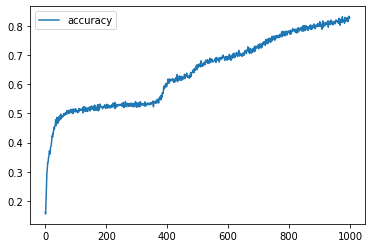

In [51]:
# plot the accuracy of the model as it trains
plt.plot(history.history['accuracy'])
plt.legend(['accuracy'])

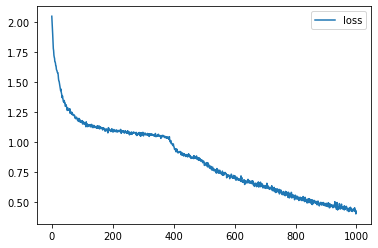

In [52]:
# plot the loss of the model as it trains
plt.plot(history.history['loss'])
plt.legend(['loss'])

### Saving the Model:

In [53]:
ls

sample_data/  Student_performance_parameters_final_without_rating.xlsx


In [54]:
cd /gdrive/MyDrive/Sem\ 8\ Major\ Project/Codes/LSTM/LSTM\ Saved\ Models/

/gdrive/MyDrive/Sem 8 Major Project/Codes/LSTM/LSTM Saved Models


In [55]:
ls

LSTM_model_sem_6_parameters_123_nrecommendations_1.h5
LSTM_model_sem_6_parameters_134_nrecommendations_1.h5


Subject_Content = True #@param {type:"boolean"}<br>
Teacher_Rating = False #@param {type:"boolean"}<br>
Subject_Interest = True #@param {type:"boolean"}<br>
Practical_Knowledge = True #@param {type:"boolean"}<br>
Likely_to_recommend = False #@param {type:"boolean"}<br>

In [56]:
model.save("LSTM_model_sem_6_parameters_1_nrecommendations_1.h5")

In [57]:
ls

LSTM_model_sem_6_parameters_123_nrecommendations_1.h5
LSTM_model_sem_6_parameters_134_nrecommendations_1.h5
LSTM_model_sem_6_parameters_1_nrecommendations_1.h5
